# Synthesizing Data 
## By: Lela Bones
-----------------------------------
### Problem
    Nestor is an application that allows users to datify their maintenance logs. Datify is the process of taking unorginized data and putting it into a quantifiable and statistically relevant format. The problem is that because of copywright and data ownership technicalities, it is hard for us to have a large amount of "good" data to demo our app on. 

### Solution
    I plan on using Reccurent Neural Nets (RNNs) to generate realistic data from the data that we already have from companies. The reason for this is because we can use the "synthetic" data to demo our app on, and we aren't breaking any laws. I plan on using a Python library, Pytorch to implement my RNN and train it on the data. 

#### Why Pytorch???
Pytorch is a framework that builds from the Torch framework that Facebook actively uses. Pytorch is extremely fast it is very native and customizable. Pytorch is also a dynamic deep learning tool, which means that you can change and execute notes as you're learning. This makes RNNs way easier to train because you don't need to set a maximum length and then pad smaller sequences. Debugging is really easy because it is defined at runtime. It works well with Flask, which is the tool that I am using to create my visual dashboard. Pytorch also has declarative data parallelism which allows you to use multiple GPUs. 

#### Why RNNs???
    * Vanilla Neural Networks relearn each iteration
    * Long Short Term Memory Neural Nets are good for long-term data
    * Maybe GRU Neural Nets, they get rid of the disappearing gradient problem
    * RNNs implement loops so the learning is compositional

### Data manipulation

In [1]:
#conda install pandas
#conda install pytorch torchvision -c pytorch
#conda install numpy
import pandas as pd
import torch
import numpy as np

In [2]:
#set data file, column you want extracted, and output file
csv_file = 'mine_raw.csv'
txt_file = 'train.txt'
text_col = 'OriginalShorttext'

In [3]:
#this function converts the column of text from your csv file 
#to a text file that has each row on a seperate line
#code modified from https://stackoverflow.com/questions/47339698/how-to-convert-csv-file-to-text-file-using-python
def createTextFile(inputFile, text, outputFile):
    df = pd.read_csv(inputFile)
    data = df[text].apply(lambda x: " ".join(x.lower() for x in x.split()))

    text_list = []
    for line in data:
        text_list.append(" ".join(line))
    
    #switch to a+ if you want to append to existing file
    with open(outputFile, "w+") as output_file:
        for line in data:
            output_file.write("  " + line + "\n")
        #verification that it's finished
        print('File Successfully written.')
    output_file.close()

In [4]:
createTextFile(csv_file, text_col, txt_file)

File Successfully written.


In [5]:
#the majority of this code was modified from https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open(txt_file).read())
file_len = len(file)
print('file_len =', file_len)

file_len = 165817


In [6]:
chunk_len = 200

#splitting up the code into random chunks each the size of 200
def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

# print(random_chunk())

### Creating the Neural Net

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [8]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([ 10,  11,  12,  39,  40,  41])


In [9]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

In [10]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [11]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

In [13]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

/home/ltb3/.conda/envs/mwo-lstm/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


 11s (100 5%) 1.9912]
Wh9ge want mhane lighang
  repld hownd cailt
  replaer linet crowal pine wandroskender sh u/h shdoin g 

 23s (200 10%) 1.6270]
Whynd ader ler ab stion leak boom sydisv ail bomh alde ling
  leat stor less uir wube pin hose tot
  r 

 36s (300 15%) 1.5306]
Wht bucket broken tooledt
  real serat ntrok rarpair serving oupps leak pumps line spipe leak ont
  re 

 48s (400 20%) 1.4541]
Whead pump slew ness
  replece cexheater
  replace booce tooth uss
  replace l/h engife repioth fipipe 

 57s (500 25%) 1.4531]
Whydraulicced
  replace a/c oning slew engine
  engine on s/o stick filter u/s
  re-lh stang ron bucke 

 7s (600 30%) 1.0949]
Whangeout leak
  change out r/h sce frowd..
  repair light huster
  replace rh start
  leaking cyling  

 18s (700 35%) 1.0445]
Whate leaking onnt brokn low macining at r/h star broken
  replace lubes buckett.2 cont
  repair low o 

 31s (800 40%) 1.2076]
Whyd calve pressor hass boom
  scope w clam filter cab
  repair oil leaking
  repla

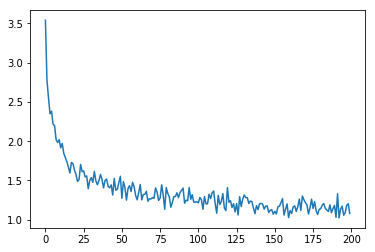

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)